In [47]:
# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import string
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau,CSVLogger
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization,Dense, Dropout, Activation,Flatten,Embedding,Conv1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import shutil


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Reading the Hate Speech Dataset

In [48]:
#Data Reading for the hate speech Dataset
nRowsRead = None # specifying 'None' to read complete file
df = pd.read_csv('labeled_data.csv', delimiter=',', nrows = nRowsRead)
nRow, nCol = df.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [49]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Text Preprocessing

In [50]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()
 
# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely as a woman you shouldnt compl...
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,3,0,2,1,1,rt cganderson vivabased she look like a tranny
4,4,6,0,6,0,1,rt shenikaroberts the shit you hear about me ...


In [51]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
            # Let's Lemmatize the word as well
            # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely woman shouldnt complain cleani...
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,1,rt cganderson vivabased look like tranny
4,4,6,0,6,0,1,rt shenikaroberts shit hear might true might f...


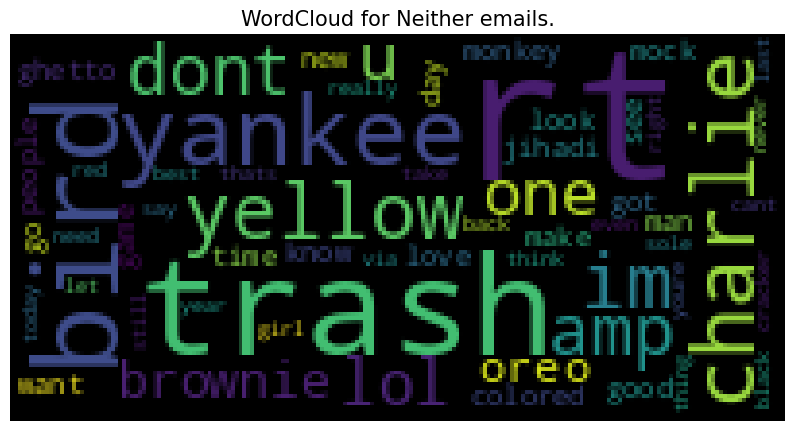

In [52]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])
 
  plt.figure(figsize = (10,10))
   
  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)
   
  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()
 
plot_word_cloud(df[df['class']==2], typ='Neither')

We see that 'rt' to be one of the important words in a dataset. This actually means retweet and is something that we can ignore for the moment

## Word2Vec Conversion
### Transforming Data

In [53]:
c=df['class']
df.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df['text']
b=df['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})
df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)

In [54]:
df.head()

,text,category,label
0,rt mayasolovely woman shouldnt complain cleani...,neither,2
1,rt mleew17 boy dats coldtyga dwn bad cuffin da...,offensive_language,1
2,rt urkindofbrand dawg rt 80sbaby4life ever fuc...,offensive_language,1
3,rt cganderson vivabased look like tranny,offensive_language,1
4,rt shenikaroberts shit hear might true might f...,offensive_language,1


In [55]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



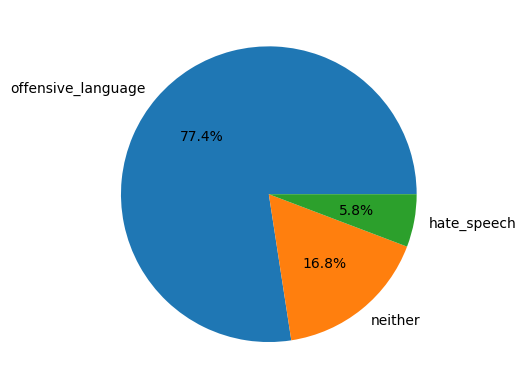

In [56]:
plt.pie(df['category'].value_counts().values,
        labels = df['category'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [57]:
x= df['text']
y=df['label']

In [58]:
texts = x
target = y

### Tokenizing Data

In [59]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)
#defining vocabulary length
vocab_length = len(word_tokenizer.word_index) + 1

In [60]:
def embed(text_data): 
  '''
  Input : text
  Output : returns a sequence of integers for input text
  ''' 
  return word_tokenizer.texts_to_sequences(text_data)

In [61]:
longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

In [62]:
train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

In [63]:
embeddings_dictionary = dict()
embedding_dim = 200

### Using GloVe

In [64]:
with open('glove.6B.200d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

In [65]:
# Loading embedding_vectors of words which comes in Glove files other will be equated to 0
#defining embedding matrix shape
embedding_matrix = np.zeros((vocab_length, embedding_dim))
#creating embedding matrix
for word, index in word_tokenizer.word_index.items(): 
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Splitting Dataset

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [67]:
X_train, x_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.1 )

## Model Development and Evaluation

In [68]:
def bilstm():
    model = Sequential()
    #adding embediing layer
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence))
    #adding Bi_lstm later
    model.add(Bidirectional(LSTM(length_long_sentence,return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPooling1D()) #globalmaxpooling_layer
    model.add(BatchNormalization()) #bath_normalisation
    model.add(Dropout(0.5)) #dropout_1
    model.add(Dense(length_long_sentence, activation = "relu")) #denselayer_1
    model.add(Dropout(0.5)) #dropout_2
    model.add(Dense(length_long_sentence, activation = "relu")) #denselayer_2
    model.add(Dropout(0.5)) #dropout_3
    model.add(Dense(3, activation = 'softmax')) #classification_layer
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


In [73]:
bilstm_model = bilstm()
bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 200)           8136600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 60)           55440     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_2 (Batc  (None, 60)               240       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 60)                0         
                                                      

In [70]:
#defining_class_weight for each class
weight_class1 = (1 / hate)*(total)/3.0 
weight_class2 = (1 / ofensive)*(total)/3.0
weight_class3 = (1 / neither)*(total)/3.0
class_weight = {0: weight_class1, 1: weight_class2, 2: weight_class3}

In [71]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

In [79]:
epoch_count=4
batch_size= 128

In [80]:
#running_model
history = bilstm_model.fit(
    X_train, 
    y_train, 
    epochs = epoch_count,
    batch_size = batch_size,
    validation_data = (x_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr],
    class_weight=class_weight
)


Epoch 1/4
131/131 [==============================] - 39s 296ms/step - loss: 0.8862 - accuracy: 0.5911 - val_loss: 0.7523 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 2/4
131/131 [==============================] - 36s 273ms/step - loss: 0.7837 - accuracy: 0.6657 - val_loss: 0.6111 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/4
131/131 [==============================] - 36s 277ms/step - loss: 0.6930 - accuracy: 0.7240 - val_loss: 0.5432 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 4/4
131/131 [==============================] - 34s 257ms/step - loss: 0.6097 - accuracy: 0.7488 - val_loss: 0.5425 - val_accuracy: 0.7692 - lr: 0.0010


In [81]:
#plotting graphs
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=17)
        ax[idx].set_xlabel('Loss ',fontsize=14)
        ax[idx].set_ylabel('Accuracy',fontsize=14)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

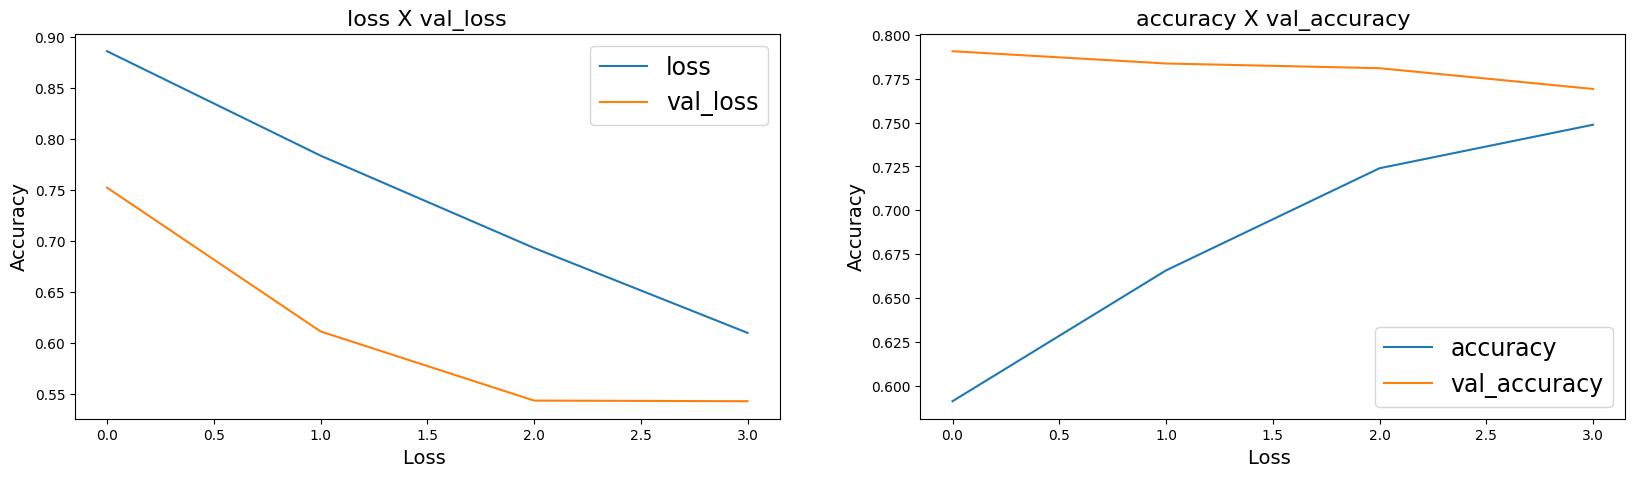

In [82]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])